# City street network orientations

Compare the spatial orientations of city street networks with OSMnx.

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd

ox.config(log_console=True, use_cache=True)
weight_by_length = False

In [29]:
# define the study sites as label : query
places = {
          'Barre'    : 'Barre, VT, USA',
          'Bennington'    : 'Bennington, VT, USA',
#          'Brandon'       : 'Brandon, VT, USA',
          'Brattleboro'   : 'Brattleboro, VT, USA',
#          'Bristol'       : 'Bristol, VT, USA',
          'Burlington'    : 'Burlington, VT, USA',
          'Essex Junction': 'Essex Junction, VT, USA',
          'Middlebury'    : 'Middlebury, VT, USA',
          'Montpelier'    : 'Montpelier, VT, USA',
          'South Burlington'    : 'South Burlington, VT, USA',
          'Rutland'       : 'Rutland, VT, USA',
          'Saint Albans'  : 'Saint Albans, VT, USA',
#          'Shelburne'    : 'Shelburne, VT, USA',
          'Vergennes'     : 'Vergennes, VT, USA',
          'Winooski'      : 'Winooski, VT, USA',
         }

In [30]:
# verify OSMnx geocodes each query to what you expect
gdf = ox.gdf_from_places(places.values())
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-72.524825,44.313509,44.234875,-72.612615,"POLYGON ((-72.61261500000001 44.258585, -72.61...","Montpelier, Washington County, Vermont, 05602,..."
1,-73.134774,44.529935,44.405378,-73.321428,"POLYGON ((-73.321428 44.516256, -73.321395 44....","South Burlington, Chittenden County, Vermont, USA"
2,-72.482864,44.216218,44.180232,-72.537486,"POLYGON ((-72.537486 44.204613, -72.5372310000...","Barre, Washington County, Vermont, USA"
3,-73.149847,42.893334,42.849950,-73.214127,"POLYGON ((-73.214127 42.876126, -73.214062 42....","Bennington, Bennington County, Vermont, 05201,..."
4,-73.238967,44.180609,44.153091,-73.272812,"POLYGON ((-73.272812 44.177193, -73.2727540000...","Vergennes, Addison County, Vermont, 05491, USA"
5,-72.532479,42.898976,42.823758,-72.681076,"POLYGON ((-72.6810763 42.8272227, -72.561289 4...","Brattleboro, Windham County, Vermont, USA"
6,-73.176585,44.539253,44.445915,-73.276914,"POLYGON ((-73.276914 44.505997, -73.2769069999...","Burlington, Chittenden County, Vermont, USA"
7,-73.081520,44.508770,44.471872,-73.144095,"POLYGON ((-73.14409499999999 44.4834, -73.1440...","Essex Junction, Chittenden County, Vermont, USA"
8,-72.945458,43.631169,43.586078,-73.011453,"POLYGON ((-73.011453 43.607273, -73.010841 43....","Rutland, Rutland County, Vermont, USA"
9,-73.166246,44.506435,44.484084,-73.202139,"POLYGON ((-73.20213939999999 44.4922422, -73.2...","Winooski, Chittenden County, Vermont, 05404, USA"


## Get the street networks and their edge bearings

In [31]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

Barre


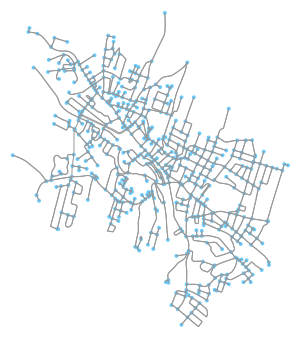

Bennington


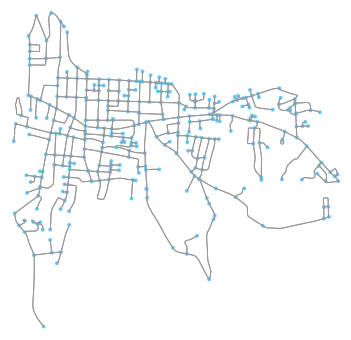

Brattleboro


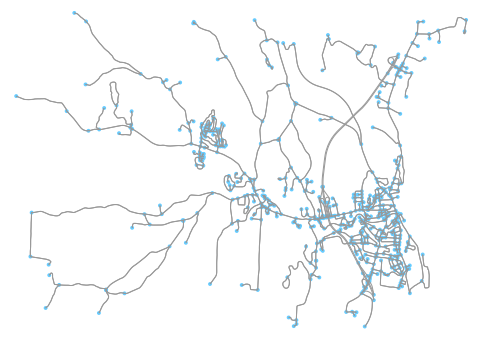

Burlington


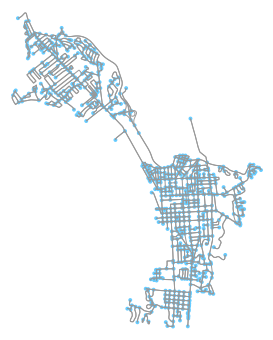

Essex Junction


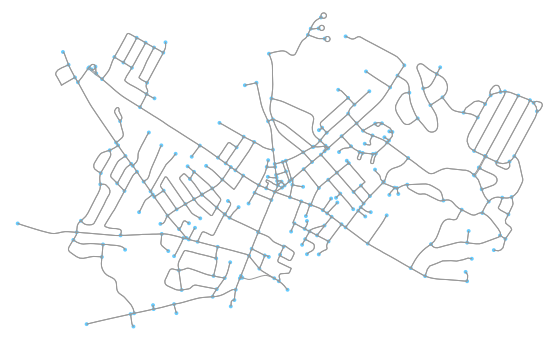

Middlebury


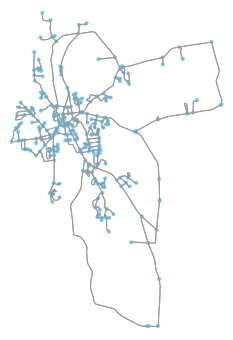

Montpelier


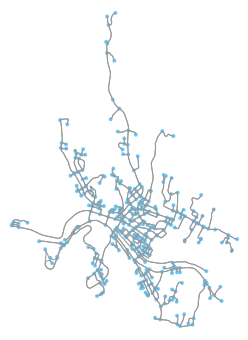

Rutland


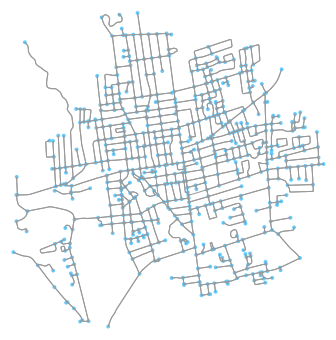

Saint Albans


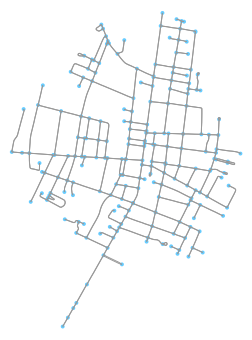

South Burlington


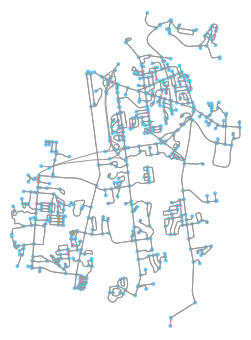

Vergennes


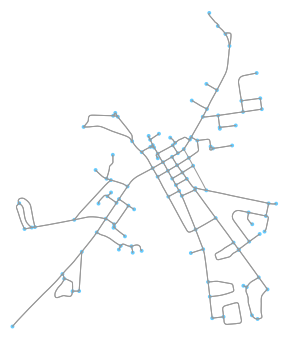

Winooski


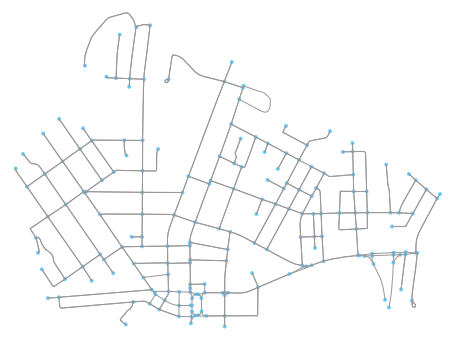

In [36]:
bearings = {}
for place in sorted(places.keys()):
    
    # get the graph
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    print(place)
    ox.plot_graph(G)
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

## Visualize it

In [33]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [34]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':25, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [35]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'DejaVu Sans', 'fontsize':30, 'fontweight':'normal', 'y':1.15}
fig.suptitle('Vermont Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
plt.close()